In [1]:
import os
import matplotlib
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from tqdm.auto import tqdm
import pickle
import time
from nlp_utils import get_cos_sim, add_text_to_image, set_default_figure_params
from quintuplets import QuadrupletId, load_quadruplet, QUINTUPLETS_DATASET_PATH, Quintuplet, visualize_quadruplet, get_splits_ids
import seaborn as sns
# sns.set_theme()

/home/dcor/roeyron/miniconda3/envs/patchscopes/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/home/dcor/roeyron/miniconda3/envs/patchscopes/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [ ]:
results_dir = '/home/dcor/roeyron/TCIE/results/qard_v2_embeddings/'
results_fnames = sorted(os.listdir(results_dir))
results_fpaths = [os.path.join(results_dir, fname) for fname in results_fnames]

splits_ids = get_splits_ids()
dict_id_to_split = {v: k for k, v in splits_ids.items()}

df = pd.concat([pd.read_pickle(fpath) for fpath in tqdm(results_fpaths)])
df['split'] = df.quintuplet_id.apply(lambda i: dict_id_to_split[i])
print(len(df))
df.head()

In [3]:
i_layer = 25  # <= 32
i_token = -1

layers = range(1, 33)

qd_ids = df[['quintuplet_id', 'which']].drop_duplicates()
qd_ids = [QuadrupletId(e.quintuplet_id, e.which) for _, e in qd_ids.iterrows()]
ddl_results = defaultdict(list)

for i_layer in layers:
    for qd_id in qd_ids:
        df_qd = df[(df.quintuplet_id == qd_id.quintuplet_id) & (df.which == qd_id.which)]
    
        hs_query = df_qd[df_qd.image_type == 'query'].iloc[0].hidden_states[i_layer, i_token]
        hs_positive = df_qd[df_qd.image_type == 'positive'].iloc[0].hidden_states[i_layer, i_token]
        hs_negative = df_qd[df_qd.image_type == 'negative'].iloc[0].hidden_states[i_layer, i_token]

        sim_p = get_cos_sim(hs_query, hs_positive)
        sim_n = get_cos_sim(hs_query, hs_negative)
        correct = sim_p > sim_n
        
        ddl_results['i_layer'].append(i_layer)
        ddl_results['i_token'].append(i_token)
        ddl_results['correct'].append(correct)
        ddl_results['sim_p'].append(sim_p)
        ddl_results['sin_n'].append(sim_n)

df_results = pd.DataFrame(ddl_results)
print(df_results.correct.mean())
print(len(df_results))

0.6364583333333333
9600


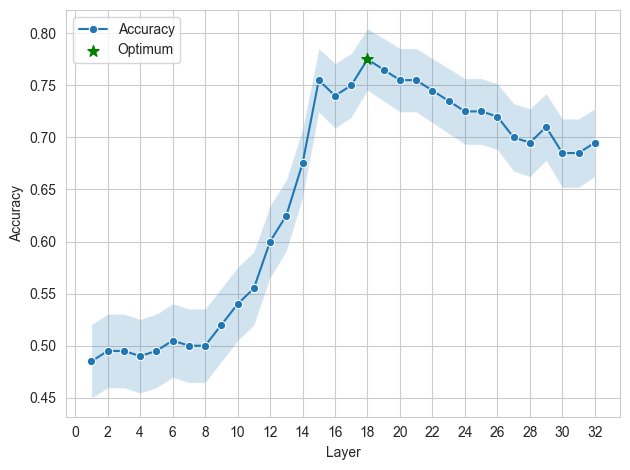

In [4]:

# Assuming df_results is your DataFrame
sr = df_results.groupby(by='i_layer')['correct'].agg(['mean', 'sem']).reset_index()
sr = sr.rename(columns={'mean': 'accuracy', 'sem': 'error'})
plt.figure()
sns.set_style("whitegrid")
ax = sns.lineplot(x='i_layer', y='accuracy', data=sr, marker='o', label='Accuracy')
plt.fill_between(sr['i_layer'], 
                 sr['accuracy'] - sr['error'], 
                 sr['accuracy'] + sr['error'], 
                 alpha=0.2, 
                 # label='Error margin'
                )
best_layer = sr.loc[sr['accuracy'].idxmax(), 'i_layer']
best_accuracy = sr['accuracy'].max()

plt.scatter([best_layer], [best_accuracy], marker='*', c='green', s=70, zorder=5, label=f'Optimum')

plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.xticks(range(0, len(sr['i_layer'])+1, 2))

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
i_token = -1

qd_ids = df[['quintuplet_id', 'which']].drop_duplicates()
qd_ids = [QuadrupletId(e.quintuplet_id, e.which) for _, e in qd_ids.iterrows()]
ddl_results = defaultdict(list)

for qd_id in qd_ids[:20]:
    df_qd = df[(df.quintuplet_id == qd_id.quintuplet_id) & (df.which == qd_id.which)]
    # for i_layer in range(0, 33):
    i_layer = best_layer
    hs_query = df_qd[df_qd.image_type == 'query'].iloc[0].hidden_states[i_layer, i_token]
    hs_positive = df_qd[df_qd.image_type == 'positive'].iloc[0].hidden_states[i_layer, i_token]
    hs_negative = df_qd[df_qd.image_type == 'negative'].iloc[0].hidden_states[i_layer, i_token]

    
    sim_p = get_cos_sim(hs_query, hs_positive)
    sim_n = get_cos_sim(hs_query, hs_negative)
    correct = sim_p > sim_n

    print(correct)
    visualize_quadruplet(QUINTUPLETS_DATASET_PATH, qd_id)
        